In [ ]:
# !pip install kaggle
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !chmod 600 /root/.kaggle/kaggle.json
# !kaggle datasets download -d aaaof96/mango-dataset-2
# !mkdir mango
# !mv mango-dataset-2.zip mango
# !cd mango
# !unzip mango-dataset-2.zip


In [3]:
# Check Pytorch installation
import torch, torchvision
print("torch version:",torch.__version__, "cuda:",torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print("mmdetection:",mmdet.__version__)

# Check mmcv installation
import mmcv
print("mmcv:",mmcv.__version__)

# Check mmengine installation
import mmengine
print("mmengine:",mmengine.__version__)


torch version: 2.0.1 cuda: True
mmdetection: 3.1.0
mmcv: 2.0.1
mmengine: 0.8.4


In [ ]:
# #clear memory GPU
# import gc
# torch.cuda.empty_cache()
# gc.collect()

In [ ]:
!mim download mmdet --config mask-rcnn_x101-32x8d_fpn_ms-poly-1x_coco --dest ./checkpoints

In [4]:
import mmcv
import mmengine
from mmdet.apis import init_detector, inference_detector
from mmdet.utils import register_all_modules
# Choose to use a config and initialize the detector
config_file = '/workspace/mmdetection/configs/mask_rcnn/mask-rcnn_x101-32x8d_fpn_ms-poly-1x_coco.py'
# Setup a checkpoint file to load
checkpoint_file = '/workspace/checkpoints/mask_rcnn_x101_32x8d_fpn_mstrain-poly_1x_coco_20220630_170346-b4637974.pth'

# register all modules in mmdet into the registries
register_all_modules()

# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')  # or device='cuda:0'


Loads checkpoint by local backend from path: /workspace/checkpoints/mask_rcnn_x101_32x8d_fpn_mstrain-poly_1x_coco_20220630_170346-b4637974.pth


In [ ]:
# # Use the detector to do inference
# image = mmcv.imread('/workspace/mmdetection/demo/demo.jpg',channel_order='rgb')
# result = inference_detector(model, image)
# print(result)

### Let's plot the result

In [ ]:
# from mmdet.registry import VISUALIZERS
# # init visualizer(run the block only once in jupyter notebook)
# visualizer = VISUALIZERS.build(model.cfg.visualizer)
# # the dataset_meta is loaded from the checkpoint and
# # then pass to the model in init_detector
# visualizer.dataset_meta = model.dataset_meta

In [ ]:
# # show the results
# visualizer.add_datasample(
#     'result',
#     image,
#     data_sample=result,
#     draw_gt = None,
#     wait_time=0,
# )
# visualizer.show()

In [ ]:
!tree ballondatasets

In [ ]:
# Let's take a look at the dataset image
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('/workspace/to_train/train/IMG_1003.jpg')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [5]:
mango_train_annotation = mmengine.load("/workspace/to_train/train/annotation_train.json")
mango_val_annotation = mmengine.load("/workspace/to_train/validate/annotation_val.json")
mango_test_annotation = mmengine.load("/workspace/to_train/test/annotation_test.json")

In [6]:
from pycocotools.coco import COCO

# Path to load the COCO annotation file
annotation_file = '/workspace/to_train/train/annotation_train.json'

# Initialise the COCO object
coco = COCO(annotation_file)

# Get all category tags and corresponding category IDs
categories = coco.loadCats(coco.getCatIds())
category_id_to_name = {cat['id']: cat['name'] for cat in categories}

# Print all category IDs and corresponding category names
for category_id, category_name in category_id_to_name.items():
    print(f"Category ID: {category_id}, Category Name: {category_name}")

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Category ID: 1, Category Name: mango


In [7]:
from mmengine import Config
cfg = Config.fromfile('/workspace/mmdetection/configs/mask_rcnn/mask-rcnn_x101-32x8d_fpn_ms-poly-1x_coco.py')

In [ ]:
cfg.keys()

In [ ]:
cfg.model

In [ ]:
bck = cfg.train_dataloader.dataset.pipeline

In [ ]:
bck

In [ ]:
 cfg.train_dataloader.dataset.pipeline = cfg.train_dataloader.dataset.pipeline[:-1]

In [ ]:
cfg.train_dataloader.dataset.pipeline.append({'type':'RandomCrop','crop_size':(800,800)})

In [ ]:
cfg.train_dataloader.dataset.pipeline

In [8]:
from mmengine.runner import set_random_seed

# Modify dataset classes and color
cfg.metainfo = {
    'classes': ('mango', ),
    'palette': [
        (220, 20, 60),
    ]
}

# Modify dataset type and path
cfg.data_root = '/workspace/to_train'

cfg.train_dataloader.dataset.ann_file = 'train/annotation_train.json'
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix.img = 'train/'
cfg.train_dataloader.dataset.metainfo = cfg.metainfo

cfg.val_dataloader.dataset.ann_file = 'validate/annotation_val.json'
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix.img = 'validate/'
cfg.val_dataloader.dataset.metainfo = cfg.metainfo

cfg.test_dataloader.dataset.ann_file = 'test/annotation_test.json'
cfg.test_dataloader.dataset.data_root = cfg.data_root
cfg.test_dataloader.dataset.data_prefix.img = 'test/'
cfg.test_dataloader.dataset.metainfo = cfg.metainfo

# cfg.test_dataloader = cfg.val_dataloader

# Modify metric config
cfg.val_evaluator.ann_file = cfg.data_root+'/'+'validate/annotation_val.json'
cfg.test_evaluator = cfg.val_evaluator

# Modify num classes of the model in box head and mask head
cfg.model.roi_head.bbox_head.num_classes = 1
cfg.model.roi_head.mask_head.num_classes = 1

# We can still the pre-trained Mask RCNN model to obtain a higher performance
cfg.load_from = '/workspace/checkpoints/mask_rcnn_x101_32x8d_fpn_mstrain-poly_1x_coco_20220630_170346-b4637974.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'


# We can set the evaluation interval to reduce the evaluation times
cfg.train_cfg.val_interval = 1
# We can set the checkpoint saving interval to reduce the storage cost
cfg.default_hooks.checkpoint.interval = 1

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optim_wrapper.optimizer.lr = 0.02 / 8
cfg.default_hooks.logger.interval = 10


# Set seed thus the results are more reproducible
# cfg.seed = 0
set_random_seed(0, deterministic=False)

# We can also use tensorboard to log the training process
# cfg.visualizer.vis_backends.append({"type":'TensorboardVisBackend'})

#------------------------------------------------------
config=f'/workspace/mmdetection/configs/mask_rcnn/mask-rcnn_r50-caffe_fpn_ms-poly-3x_coco.py'
with open(config, 'w') as f:
    f.write(cfg.pretty_text)

In [ ]:
cfg.keys()

In [ ]:
cfg.test_dataloader

In [9]:
from mmengine.runner import Runner

# build the runner from config
runner = Runner.from_cfg(cfg)
runner.train()

09/12 18:51:29 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.11 (main, Apr 20 2023, 19:02:41) [GCC 11.2.0]
    CUDA available: True
    numpy_random_seed: 209652396
    GPU 0: Tesla V100-SXM2-16GB
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.7, V11.7.99
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 2.0.1
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50

MaskRCNN(
  (data_preprocessor): DetDataPreprocessor()
  (backbone): ResNeXt(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): 

In [10]:
runner.test()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
09/12 19:12:19 - mmengine - INFO - Epoch(test) [10/18]    eta: 0:00:11  time: 1.4789  data_time: 0.5637  memory: 3769  
09/12 19:12:40 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...


AssertionError: Results do not correspond to current coco set

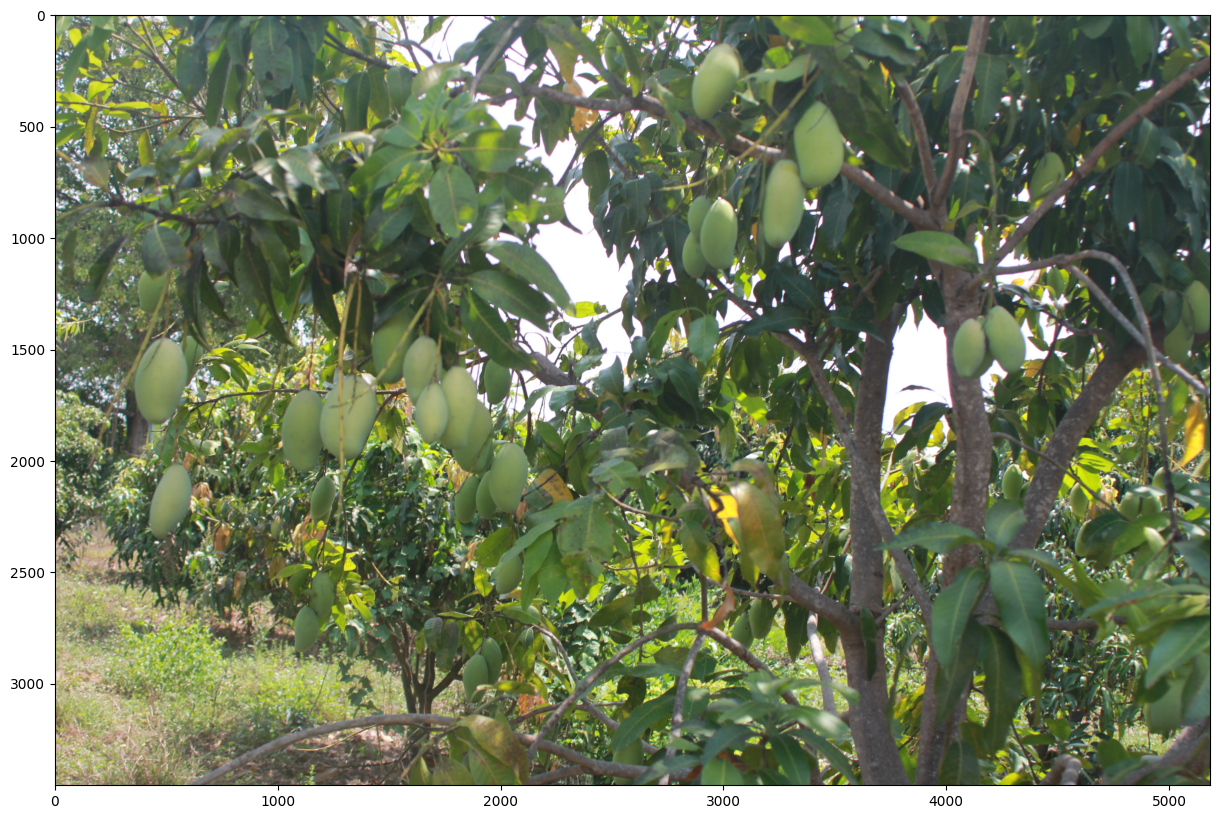

In [11]:
import matplotlib.pyplot as plt
img = mmcv.imread('/workspace/to_train/test/IMG_9428.jpg')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [14]:
import mmcv
from mmdet.apis import init_detector, inference_detector

img = mmcv.imread("/workspace/to_train/test/IMG_9428.jpg",channel_order='rgb')
checkpoint_file = '/workspace/tutorial_exps/epoch_12.pth'
model = init_detector(cfg, checkpoint_file, device='cpu')
new_result = inference_detector(model, img)



Loads checkpoint by local backend from path: /workspace/tutorial_exps/epoch_12.pth


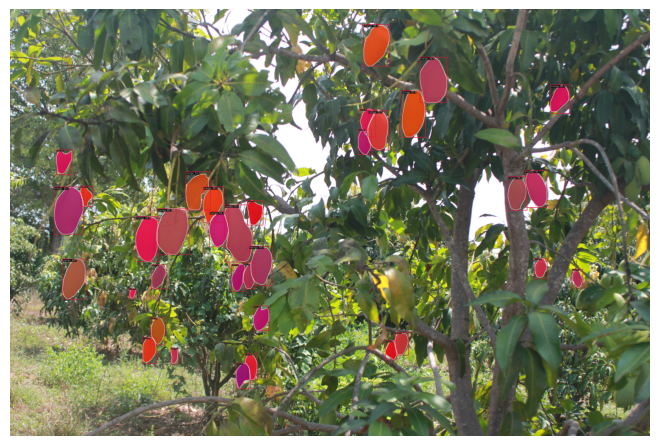

In [15]:
from mmengine.visualization import Visualizer

# get built visualizer
visualizer_now = Visualizer.get_current_instance()

visualizer_now.dataset_meta = model.dataset_meta

visualizer_now.add_datasample(
    'new_result',
    img,
    data_sample=new_result,
    draw_gt=False,
    wait_time=0,
    out_file=None,
    pred_score_thr=0.5
)

visualizer_now.show()